In [1]:
from abc import ABC
import numpy as np
import pandas as pd
import random
import os
import time

from functools import lru_cache
from path import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.modules.loss as L
import torch.nn.functional as F

from haversine import haversine, haversine_vector, Unit


# dtype = torch.float32
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# # device = torch.device("cpu")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly

from tqdm import tqdm, trange

from dataset import TrackDataset as TrackDatasetCurvature, TrajectoryDataset

In [3]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10', 'traffic']


In [4]:
plt.style.use('seaborn-whitegrid')
# plt.rcParams['font.size'] = None

In [4]:
from dl_model_v6_dynamic_seq import *

model = load_model(r'model/v6_dynamic_seq_10_40/CONVO-GRU-model-server2.013_22_10.pt')
model.eval()

TpDeepModel(
  (encoder): Encoder(
    (feature): Sequential(
      (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): Flatten()
      (3): Linear(in_features=128, out_features=32, bias=True)
      (4): ReLU()
    )
  )
  (decoder): Decoder(
    (gru): GRU(48, 32, batch_first=True)
    (fc_out): Linear(in_features=80, out_features=3, bias=True)
  )
)

In [5]:
# flight_id = '1fe1e79b'
flight_id = '1febf31e'
data_path = Path(r'data/train_data15_VIR_WP/flight_data.csv')
dataset = TrajectoryDataset(data_path, path_format='{date}_track_data_15.csv.gz')

In [6]:
df = pd.DataFrame(dataset.flight_data)
df.columns

Index(['Index', 'row_id', 'date', 'flight_id', 'callsign', 'registration',
       'status', 'code', 'origin_airport', 'destination_airport', 'STD', 'STA',
       'ATD', 'ATA', 'ETD', 'ETA', 'flighttime_average', 'delay_average'],
      dtype='object')

In [7]:
flight_df = dataset[flight_id]
print(dataset.flight_data[dataset._flight_id_dict[flight_id]])

Row(Index=649, row_id=19941, date='2019-03-25', flight_id='1febf31e', callsign='CSC8093', registration='B-8958', status='landed', code='A20N', origin_airport='ZUUU', destination_airport='WSSS', STD=1553492100.0, STA=1553510400.0, ATD=1553492614.0, ATA=1553509541.0, ETD=nan, ETA=1553509485.0, flighttime_average=17051, delay_average=-545)


In [ ]:
wps = flight_df[['ident', 'wp_lat', 'wp_lon']].drop_duplicates(keep='first')

flight_df['c'] = flight_df['curvature'] < 1./80

fig = px.scatter(flight_df, x='lon', y='lat',color='c', hover_data=['timestamp', 'alt', 'curvature'])
fig.add_trace(px.scatter(wps, x='wp_lon', y='wp_lat', text='ident').data[0])

fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

In [ ]:
dataset = TrajectoryDataset(data_path, usecols=USECOLS, 
                            path_format='{date}_track_data_15.csv.gz')
flight_df = dataset[flight_id]
track = TrackDataset(flight_df, n_input=INPUT_SEQ_LEN, n_output=OUTPUT_SEQ_LEN, step=2)

In [ ]:
model.eval()
track_loss = 0

step = 0
# path = Path(f'images/samples/{flight_id}')
# if not path.exists(): 
#     path.mkdir()
with torch.no_grad():
    dataloader = DataLoader(track, batch_size=200, num_workers=0)
    n_pred = len(PREDICT_COLS)

    for i, (input_seq_np, output_seq_np, n_seq, (_, phase)) in enumerate(dataloader):
        input_seq = input_seq_np.to(device=device, dtype=dtype)
        # input_seq = [batch, n_points, n_features]
        output_seq = output_seq_np.to(device=device, dtype=dtype)
        # output_seq = [batch, n_points, n_features]

        inputs = input_seq.permute(0, 2, 1)  # [batch, n_features, n_points] for time-series
        outputs = output_seq[:, :, :n_pred]  # only get lat, lon, alt
        waypoints = output_seq[:, :, n_pred:]

        n_points = outputs.shape[1]

        pred_outputs = model(inputs, n_points, waypoints, 0)
        loss, velo_loss, replacement_loss = compute_loss(pred_outputs, outputs, n_seq)
        print(f"Loss: {loss.item()}, Displacement Loss: {replacement_loss.item()}, Velocity Loss: {velo_loss.item()}")
        # ...log a Matplotlib Figure showing the model's predictions on a
        # random mini-batch
        for j in range(0, pred_outputs[0].shape[0]):
            pred_output = pred_outputs[0][j, :n_seq[j], :2].cpu().detach().numpy()
            wp = np.unique(np.vstack((input_seq_np[j, :, 3:5], input_seq_np[j, :, 5:7])), axis=0)
            fig = plot_traj(input_seq_np[j, :n_seq[j], :2], output_seq_np[j, :n_seq[j], :2], pred_output, wp, figsize=(25, 25))
#             fig.savefig(path / f'{step}.jpg')
            step +=1


In [6]:
class Stat:
    total_error = np.zeros(OUTPUT_SEQ_LEN)
    total_error_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count = np.zeros(OUTPUT_SEQ_LEN)
    
    total_error_phase1 = np.zeros(OUTPUT_SEQ_LEN)
    total_error_phase1_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count_phase1 = np.zeros(OUTPUT_SEQ_LEN)
    
    total_error_phase2 = np.zeros(OUTPUT_SEQ_LEN)
    total_error_phase2_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count_phase2 = np.zeros(OUTPUT_SEQ_LEN)
    
    total_error_phase3 = np.zeros(OUTPUT_SEQ_LEN)
    total_error_phase3_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count_phase3 = np.zeros(OUTPUT_SEQ_LEN)
    
    total_error_phase4 = np.zeros(OUTPUT_SEQ_LEN)
    total_error_phase4_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count_phase4 = np.zeros(OUTPUT_SEQ_LEN)
    
    all_errors = []

In [7]:
def compute_loss(output, true_loc, n_seq, phases=None, flight_id=None, origin=None):
    mse = lambda v: (v**2).sum(axis=1)
    mse2d = lambda v1, v2: mse(v1 - v2)
    pred_loc, velo_diff = output

    n_total = n_seq.sum()
    replacement_loss = torch.tensor([0.], device=pred_loc.device)
    velo_loss = torch.tensor([0.], device=pred_loc.device)
    phases = phases.cpu().detach().numpy()
    for i, n in enumerate(n_seq):
        phase = phases[i]
        
        rel_er = pred_loc[i, :n, :2] - true_loc[i, :n, :2]
        
        t = rel_er.cpu().detach().numpy()
#         t[n:, :] = 0
        Stat.all_errors.append(dict(
            pred_loc=pred_loc[i, :, :].cpu().detach().numpy(), 
            true_loc=true_loc[i, :, :].cpu().detach().numpy(), 
            length=n,
            phase=phase,
            fid=flight_id,
            origin=(origin[0][i], origin[1][i]),
        ))
        
        rel_er = rel_er[:n, :]
        er = mse(rel_er)
        
        replacement_loss += er.sum()
        Stat.total_error[:n] += er.cpu().detach().numpy()
        Stat.total_error_mape[:n] += np.sqrt(er.cpu().detach().numpy())
        Stat.total_count[:n] += 1
        # velo_loss += mse(velo_diff[i, :n, :])
        
        if phase == 1: 
            Stat.total_error_phase1[:n] += er.cpu().detach().numpy()
            Stat.total_error_phase1_mape[:n] += np.sqrt(er.cpu().detach().numpy())
            Stat.total_count_phase1[:n] += 1
        elif phase == 2: 
            Stat.total_error_phase2[:n] += er.cpu().detach().numpy()
            Stat.total_error_phase2_mape[:n] += np.sqrt(er.cpu().detach().numpy())
            Stat.total_count_phase2[:n] += 1
        elif phase == 3: 
            Stat.total_error_phase3[:n] += er.cpu().detach().numpy()
            Stat.total_error_phase3_mape[:n] += np.sqrt(er.cpu().detach().numpy())
            Stat.total_count_phase3[:n] += 1
        elif phase == 4: 
            Stat.total_error_phase4[:n] += er.cpu().detach().numpy()
            Stat.total_error_phase4_mape[:n] += np.sqrt(er.cpu().detach().numpy())
            Stat.total_count_phase4[:n] += 1
            
        
    replacement_loss = torch.sqrt(replacement_loss / n_total)
    # velo_loss = torch.sqrt(velo_loss / n_total)
    loss = replacement_loss + ALPHA * velo_loss
    return loss, velo_loss, replacement_loss
    
    
def evaluate(
        model: nn.Module,
        track: TrackDataset,
        criterion,
        flight_id,
):
    model.eval()
    track_loss = 0

    with torch.no_grad():
        dataloader = DataLoader(track, batch_size=256,
                                shuffle=False, num_workers=4, pin_memory=True)
        n_pred = len(PREDICT_COLS)

        for i, (input_seq_np, output_seq_np, n_seq, phase, origin) in enumerate(dataloader):
            input_seq = input_seq_np.to(device=device, dtype=dtype)
            # input_seq = [batch, n_points, n_features]
            output_seq = output_seq_np.to(device=device, dtype=dtype)
            # output_seq = [batch, n_points, n_features]

            inputs = input_seq.permute(0, 2, 1)  # [batch, n_features, n_points] for time-series
            outputs = output_seq[:, :, :n_pred]  # only get lat, lon, alt

            waypoints = output_seq[:, :, n_pred:]

            n_points = outputs.shape[1]

            pred_outputs = model(inputs, n_points, waypoints, 0)
            loss, velo_loss, replacement_loss = compute_loss(pred_outputs, outputs, n_seq, phase, flight_id, origin)


In [77]:
time_step = 15
test_path = f'./data/train_data{time_step}_VIR_WP/flight_data_small_train.csv'
# test_path = f'./data/train_data{time_step}/flight_data_small_test.csv'
test_ds = TrajectoryDataset(test_path, usecols=USECOLS + ['curvature'],
                            path_format="{date}_track_data_" + str(time_step) + ".csv.gz")
max_points = 1000 * (30. / time_step)
min_points = 150 * (30. /time_step)

count = 0

for i in trange(len(test_ds)):
    df = test_ds[i].reset_index(drop=True)
    if df.shape[0] < min_points or df.shape[0] > max_points: continue
    track = TrackDatasetCurvature(
        df[USECOLS], n_input=INPUT_SEQ_LEN, n_output=OUTPUT_SEQ_LEN,
        curvature_values=df['curvature'], curvature_threshold=1/50.)
    count += len(track)
count

100%|██████████| 690/690 [00:09<00:00, 75.68it/s]


358294

In [8]:
time_step = 15
test_path = f'./data/train_data{time_step}_VIR_WP/flight_data_small_test.csv'
# test_path = f'./data/train_data{time_step}/flight_data_small_test.csv'
test_ds = TrajectoryDataset(test_path, usecols=USECOLS + ['curvature'],
                            path_format="{date}_track_data_" + str(time_step) + ".csv.gz")
max_points = 1000 * (30. / time_step)
min_points = 150 * (30. /time_step)

for i in trange(len(test_ds)):
    df = test_ds[i].reset_index(drop=True)
    if df.shape[0] < min_points or df.shape[0] > max_points: continue
    track = TrackDatasetCurvature(
        df[USECOLS], n_input=INPUT_SEQ_LEN, n_output=OUTPUT_SEQ_LEN,
        curvature_values=df['curvature'], curvature_threshold=1/50.)

    valid_loss_iter = evaluate(model, track, criterion, test_ds.flight_data[i].code)
#     print(f'{test_ds.flight_data[i].flight_id} flight size: {df.shape}\t')

  0%|          | 0/2192 [00:00<?, ?it/s]/home/viethoangcr/anaconda3/envs/lstm-tp/lib/python3.7/site-packages/torch/nn/modules/rnn.py:735: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
100%|██████████| 2192/2192 [53:16<00:00,  1.46s/it]


In [10]:
df1 = pd.DataFrame({
    'count': Stat.total_count,
    'RMSE': np.sqrt(Stat.total_error / Stat.total_count)
}, index=[f'{(i+1)*15/60} minutes' for i in range(OUTPUT_SEQ_LEN)])

In [ ]:
df_segment = pd.DataFrame({
    'Total_Count': Stat.total_count,
    'Total_RMSE': np.sqrt(Stat.total_error / Stat.total_count),
    'Total_MAE': Stat.total_error_mape / Stat.total_count,
    
    'Phase1_count': Stat.total_count_phase1,
    'Straight_RMSE': np.sqrt(Stat.total_error_phase1 / Stat.total_count_phase1),
    'Straight_MAE': Stat.total_error_phase1_mape / Stat.total_count_phase1,
    
    'Phase2_count': Stat.total_count_phase2,
    'Phase2_RMSE': np.sqrt(Stat.total_error_phase2 / Stat.total_count_phase2),
    'Phase2_MAE': Stat.total_error_phase2_mape / Stat.total_count_phase2,
    
    'Phase3_count': Stat.total_count_phase3,
    'Phase3_RMSE': np.sqrt(Stat.total_error_phase3 / Stat.total_count_phase3),
    'Phase3_MAE': Stat.total_error_phase3_mape / Stat.total_count_phase3,
    
    'Phase4_count': Stat.total_count_phase4,
    'Curved_RMSE': np.sqrt(Stat.total_error_phase4 / Stat.total_count_phase4),
    'Curved_MAE': Stat.total_error_phase4_mape / Stat.total_count_phase4,
    
}, index=[f'{(i+1)*15/60} minutes' for i in range(OUTPUT_SEQ_LEN)])
df_segment.iloc[np.arange(3, 40, 4), :]

In [ ]:
df_segment.iloc[np.arange(3, 40, 4), :].round(3)

In [ ]:
df_segment.iloc[np.arange(3, 40, 4), :]

In [ ]:
from utils import enu2lla
result_lla = []
for item in tqdm(Stat.all_errors):
    pred_loc, true_loc, n_, org = item['pred_loc'], item['true_loc'], item['length'], item['origin']
    i=0
    p_loc, t_loc = pred_loc[i], true_loc[i]
    
    p_loc = np.array(enu2lla(*p_loc, org[0].item(), org[1].item(), h0=0))
    t_loc = np.array(enu2lla(*t_loc, org[0].item(), org[1].item(), h0=0))
    
    result_lla.append(p_loc - t_loc)
        
        

In [ ]:
df_lla = pd.DataFrame(result_lla)
df_lla.abs().mean()

In [ ]:
np.sqrt((df_lla.abs()**2).mean())

In [11]:
import pickle

with open('result_vir_wp_more1.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(Stat.all_errors, f, pickle.HIGHEST_PROTOCOL)

import pickle

# with open('result_vir_wp.pickle', 'rb') as f:
with open('result_vir_wp_more1.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    Stat.all_errors = pickle.load(f)

In [12]:
import math
from collections import namedtuple  

Metrics = namedtuple('Metrics',['ee','ate','cte', 'ae', 'alt_err', 'calibrated_ae'])
# earth_radius_ft = 20902230.971129
earth_radius_nm = 3440.1

In [13]:
def compute_course_angle(cur_loc, pre_loc=None):
    if pre_loc is not None:
        return np.arctan2(cur_loc[0]-pre_loc[0], cur_loc[1]-pre_loc[1])
    else:
        return np.arctan2(cur_loc[0], cur_loc[1])

def metrics(t_loc, p_loc, course_angle):
    """ course_angle is the angle of track and y-axis
    
    Return: along_track_error, cross_track_error, alt_error
    """
    v = p_loc - t_loc
    ate = v[0] * math.sin(course_angle) + v[1] * math.cos(course_angle)
    cte = v[0] * math.cos(course_angle) - v[1] * math.sin(course_angle)
    alt_1 = earth_radius_nm + p_loc[2]
    alt_err = math.sqrt((p_loc[:2]**2).sum() + (alt_1)**2) - alt_1
    
    return Metrics(np.sqrt((v**2).sum()), abs(ate), abs(cte), abs(v[2]), alt_err, abs(v[2] - alt_err))


In [14]:
result = {i:[] for i in range(40)}
for item in tqdm(Stat.all_errors):
    pred_loc, true_loc, n_ = item['pred_loc'], item['true_loc'], item['length']
    for i in range(n_):
        p_loc, t_loc = pred_loc[i], true_loc[i]
        angle = compute_course_angle(t_loc) if i == 0 else compute_course_angle(t_loc, true_loc[i-1])
        result[i].append(metrics(t_loc, p_loc, angle))

100%|██████████| 1130913/1130913 [36:14<00:00, 520.01it/s] 


In [15]:
dfs = [pd.DataFrame(result[t]) for t in range(40)]
ee_data = [tdf.ee for tdf in dfs]

# ee_data = [tdf.ee[tdf.ee < tdf.ee.quantile(.95)] for tdf in dfs]
ee_data = [tdf.ee for tdf in dfs[3::4]]

# ate_data = [tdf.ate[tdf.ate < tdf.ate.quantile(.95)] for tdf in dfs]
ate_data = [tdf.ate for tdf in dfs[3::4]]

# cte_data = [tdf.cte[tdf.cte < tdf.cte.quantile(.95)] for tdf in dfs[3::4]]
cte_data = [tdf.cte for tdf in dfs[3::4]]

ae_data = [tdf.ae*6076.12 for tdf in dfs[3::4]]
ae_data_calibrated = [(tdf.calibrated_ae)*6076.12 for tdf in dfs[3::4]]

In [ ]:
t_ate = [tdf.ate[tdf.ate < tdf.ate.quantile(.99)] for tdf in dfs[3::4]]
t_cte = [tdf.cte[tdf.cte < tdf.cte.quantile(.99)] for tdf in dfs[3::4]]

In [ ]:
df_ate = pd.DataFrame([(dt_ate.mean(), dt_ate.std()) for dt_ate in t_ate], columns=['Mean', 'Std'],
            index=[f'{i+1} mins' for i in range(10)])
df_ate['mean_avg'] = df_ate['Mean'] / np.array(range(1,11))
df_ate['std_avg'] = df_ate['Std'] / np.array(range(1,11))
df_ate.round(3)

In [ ]:
df_cte = pd.DataFrame([(dt_cte.mean(), dt_cte.std()) for dt_cte in t_cte], columns=['Mean', 'Std'],
            index=[f'{i+1} mins' for i in range(10)])
df_cte['mean_avg'] = df_cte['Mean'] / np.array(range(1,11))
df_cte['std_avg'] = df_cte['Std'] / np.array(range(1,11))
df_cte.round(3)

In [ ]:
df_ate[['Mean', 'Std']].diff().round(3)

In [ ]:
df_cte[['Mean', 'Std']].diff().round(3)

fig, ax = plt.subplots(figsize=(10, 7))


# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE) 
bp = ax.boxplot(ee_data, showfliers=False) 
plt.savefig('figures/ee2.eps', format='eps')
# plt.savefig('figures/ee.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
bp = ax.boxplot(ee_data, showfliers=False) 
plt.legend(loc="upper left")
plt.xlabel('Minutes')
plt.ylabel('Error (nm)')
plt.savefig('figures/ee2.eps', format='eps')
# plt.savefig('figures/ee.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
bp = ax.boxplot(ate_data, showfliers=False) 
plt.legend(loc="upper left")
plt.xlabel('Minutes')
plt.ylabel('Error (nm)')
plt.savefig('figures/ate2.eps', format='eps')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
bp = ax.boxplot(cte_data, showfliers=False) 
plt.legend(loc="upper left")
plt.xlabel('Minutes')
plt.ylabel('Error (nm)')
plt.savefig('figures/cte2.eps', format='eps')
plt.show()

In [30]:
len(ate_data[4])

1107944

## Histogram for ATE and CTE

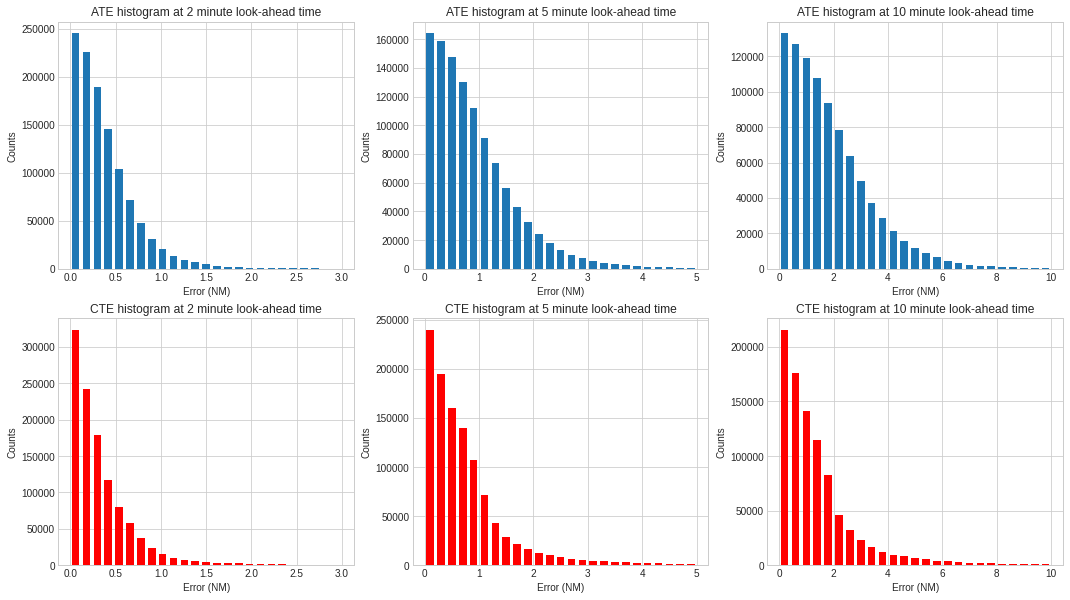

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ate_data[1][ate_data[1] <= 3].hist(bins=25, ax=axes[0,0], rwidth=0.7)
axes[0,0].set(title="ATE histogram at 2 minute look-ahead time", xlabel='Error (NM)', ylabel='Counts')

ate_data[4][ate_data[4] <= 5].hist(bins=25, ax=axes[0,1], rwidth=0.7)
axes[0,1].set(title="ATE histogram at 5 minute look-ahead time", xlabel='Error (NM)', ylabel='Counts')

ate_data[9][ate_data[9] <= 10].hist(bins=25, ax=axes[0,2], rwidth=0.7)
axes[0,2].set(title="ATE histogram at 10 minute look-ahead time", xlabel='Error (NM)', ylabel='Counts')


cte_data[1][cte_data[1] <= 3].hist(bins=25, ax=axes[1,0], rwidth=0.7, color='red')
axes[1,0].set(title="CTE histogram at 2 minute look-ahead time", xlabel='Error (NM)', ylabel='Counts')

cte_data[4][cte_data[4] <= 5].hist(bins=25, ax=axes[1,1], rwidth=0.7, color='red')
axes[1,1].set(title="CTE histogram at 5 minute look-ahead time", xlabel='Error (NM)', ylabel='Counts')

cte_data[9][cte_data[9] <= 10].hist(bins=25, ax=axes[1,2], rwidth=0.7, color='red')
axes[1,2].set(title="CTE histogram at 10 minute look-ahead time", xlabel='Error (NM)', ylabel='Counts')


plt.savefig('figures/histogram_ate_cte.eps', format='eps')
plt.show()

In [63]:
ate_data[1][ate_data[1] <= 3].hist(bins=40, rwidth=0.7, ax=axes[0,1])

NameError: name 'axes' is not defined

<AxesSubplot:>

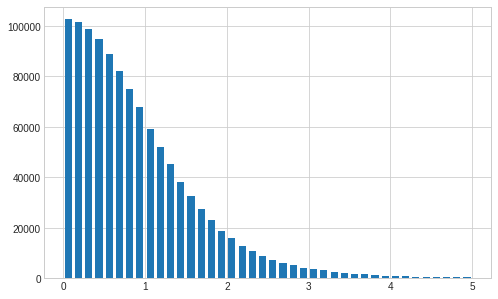

In [62]:
ate_data[4][ate_data[4] <= 5].hist(bins=40, figsize=(8,5), rwidth=0.7)
# plt.xlabel('Minutes')
# plt.ylabel('Error (nm)')
# plt.savefig('figures/ate2.eps', format='eps')

<AxesSubplot:>

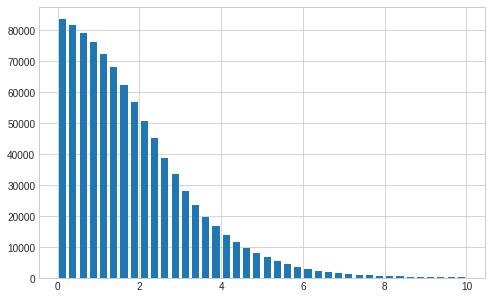

In [57]:
ate_data[9][ate_data[9] < 10].hist(bins=40, figsize=(8,5), rwidth=0.7)

No handles with labels found to put in legend.


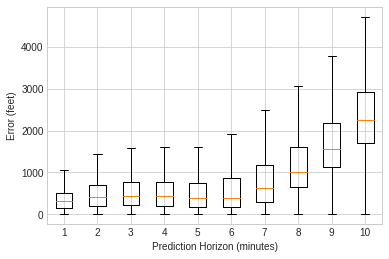

In [16]:
fig, ax = plt.subplots(figsize =(6, 4))
bp = ax.boxplot(ae_data, showfliers=False) 
plt.legend(loc="upper left")
plt.xlabel('Prediction Horizon (minutes)')
plt.ylabel('Error (feet)')
# plt.savefig('figures/ae2.eps', format='eps')
plt.show()

No handles with labels found to put in legend.


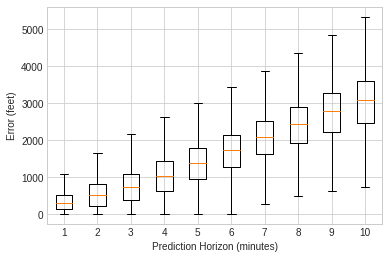

In [17]:
fig, ax = plt.subplots(figsize =(6, 4))
bp = ax.boxplot(ae_data_calibrated, showfliers=False) 
plt.legend(loc="upper left")
plt.xlabel('Prediction Horizon (minutes)')
plt.ylabel('Error (feet)')
# plt.savefig('figures/ae2.eps', format='eps')
plt.show()

In [ ]:
df1.iloc[np.arange(3, 40, 4), :]

In [ ]:
df1.plot(y='RMSE', figsize=(20,7))

In [ ]:
df = pd.DataFrame({
    'count': Stat.total_count,
    'RMSE': np.sqrt(Stat.total_error / Stat.total_count)
}, index=[f'{(i+1)*15/60} minutes' for i in range(OUTPUT_SEQ_LEN)])
df.iloc[np.arange(3, 40, 4), :]


df_segment.plot(x=[(i+1)*15/60 for i in range(OUTPUT_SEQ_LEN)], 
                y='Total_RMSE', figsize=(10,7))

In [ ]:
df_actype = pd.read_csv('./data/train_data15_VIR_WP/flight_data_small_test.csv')
df_actype.head()

In [ ]:
t.code[t['count'] < 20]

In [ ]:
# df_actype['ac_type'] = df_actype.code.replace(AC_WTC).replace({'H': 'Heavy', 'M': 'Medium'})
t = df_actype.groupby('code')['flight_id'].count().reset_index(name='count')

df_actype[df_actype['code'].isin(t.code[t.count < 20].uniques))
t = df_actype.groupby('code')['flight_id'].count().reset_index(name='count')

t['ac_type'] = t.code.replace(AC_WTC).replace({'H': 'Heavy', 'M': 'Medium'})

In [ ]:
colors = {'Medium':'r', 'Heavy':'blue'}        
color_labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in color_labels]


t1 = t[t['ac_type'].isin(['Medium', 'Heavy'])].sort_values(['ac_type', 'count'], ascending=[True, False])
ax = t1.plot.barh(x='code', y='count', width=0.6,
                 color=t.ac_type.map(colors), rot=0, figsize=(10,7),
                )
rects = ax.patches

# Make some labels.
labels = [f'{i}' for i in t1['count']]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    
    ax.text(rect.get_width() + 5, rect.get_y() + height / 2,  label,
            ha='left', va='center')
ax.set_ylabel('Aircraft Type')
ax.set_xlabel('Number of ACs')

plt.legend(handles, color_labels, loc='lower right')
# handles, labels = ax.get_legend_handles_labels()

plt.savefig('figures/ac_type_dist.eps', format='eps')

In [ ]:
list(handles)[0]

In [ ]:
AC_WTC = {
    'A320': 'M', 'A319': 'M', 'A321': 'M', 'A333': 'H', 
    'A359': 'H', 'A20N': 'M', 'A388': 'H', 'A332': 'H', 
    'A21N': 'M', 
    'B738': 'M', 'B77W': 'H', 'B78X': 'H', 'B772': 'H', 
    'B789': 'H', 'B763': 'H', 'B744': 'H', 'B788': 'H',
    'B748': 'H', 'B773': 'H', 'B77L': 'H', 'B739': 'M'
}

In [ ]:
Stat.result_M = {i:[] for i in range(40)}
Stat.result_H = {i:[] for i in range(40)}
for item in tqdm(Stat.all_errors):
    pred_loc, true_loc, n_, fid = item['pred_loc'], item['true_loc'], item['length'], item['fid']
    ac_type = AC_WTC.get(fid)
    if ac_type == 'M':
        result_t = Stat.result_M
    elif ac_type == 'H':
        result_t = Stat.result_H
    else:
        continue
    for i in range(n_):
        p_loc, t_loc = pred_loc[i], true_loc[i]
        angle = compute_course_angle(t_loc) if i == 0 else compute_course_angle(t_loc, true_loc[i-1])
        result_t[i].append(metrics(t_loc, p_loc, angle))

In [ ]:
m_mean = [pd.DataFrame(Stat.result_M[t]).mean() for t in range(40)]
h_mean = [pd.DataFrame(Stat.result_H[t]).mean() for t in range(40)]

In [ ]:
m_df = pd.DataFrame(m_mean)
h_df = pd.DataFrame(h_mean)

In [ ]:
plt.figure(figsize=(10, 7))

t = [i*15/60 for i in range(1, 41)]
plt.plot(t, m_df.ee, 'r-', label='Medium aircraft')
plt.plot(t, h_df.ee, 'b-', label='Heavy aircraft')
plt.legend(loc="upper left")
plt.xlabel('Minutes')
plt.ylabel('Error (nm)')
plt.savefig('figures/performance_by_ac_type.eps', format='eps')
plt.show()